describe in written English the methods you used to perform your analysis from beginning to end that narrates the code that does the analysis.  
your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
- note: all tables and figure should have a figure/table number and a legend


In [1]:
library(tidyverse)
library(tidymodels)
install.packages("janitor") # for clean_names
library(janitor)
install.packages("kknn")
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [5]:
set.seed(1234)

# add captions for images

# read data from web
bike_url <- "https://raw.githubusercontent.com/caiwwei/dsci-project-4/main/SeoulBikeData.csv"
bike_data <- read_csv(bike_url) |>
    clean_names() # tidy column names in dataset to contain no spaces

# showing a glance of raw data with clean names
head(bike_data)

Rows: 8760 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Date, Seasons, Holiday, Functioning Day
dbl (10): Rented Bike Count, Hour, Temperature_Celsius, Humidity, Wind speed...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


date,rented_bike_count,hour,temperature_celsius,humidity,wind_speed_m_per_s,visibility_10m,dew_point_temperature_celsius,solar_radiation,rainfall_mm,snowfall_cm,seasons,holiday,functioning_day
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Yes
01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,Yes


date,avg_temp,total_users
<chr>,<dbl>,<dbl>
01/01/2018,-1.283333,4290
01/02/2018,-3.866667,5377
01/03/2018,0.450000,5132
01/04/2018,15.183333,17388
01/05/2018,20.341667,26820
01/06/2018,23.708333,31928


date,avg_temp,total_users
<chr>,<dbl>,<dbl>
31/03/2018,13.941667,19247
31/05/2018,20.525000,31681
31/07/2018,32.525000,22897
31/08/2018,25.558333,27817
31/10/2018,7.529167,21545
31/12/2017,0.087500,3423


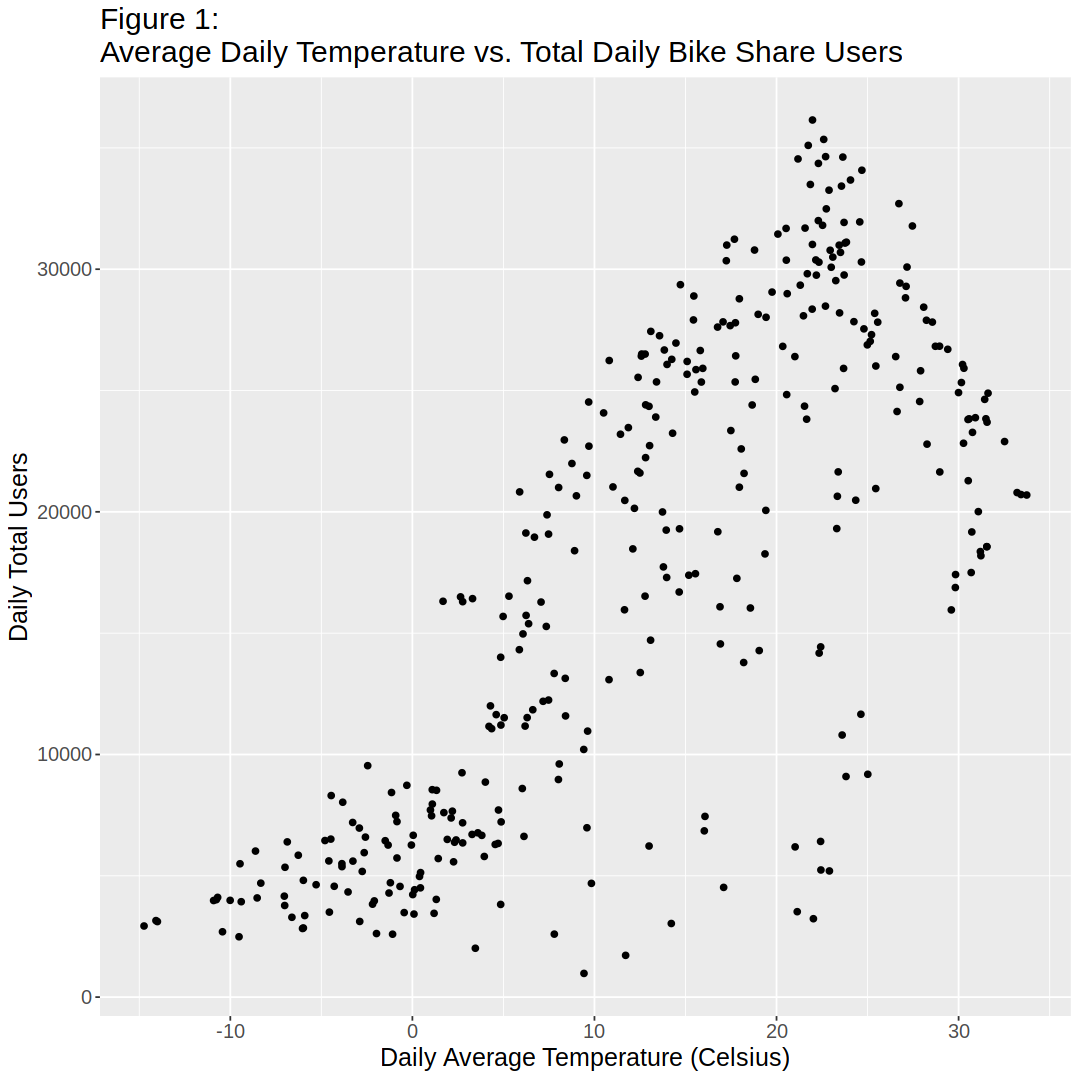

In [21]:
set.seed(1234)

# convert data observations from hourly to daily by computing total daily users and average daily temperature
bike_condensed <- bike_data |>
    group_by(date) |> 
    filter(functioning_day == "Yes") |> # because we only care about days where the bike share service is operating
    summarize(avg_temp = mean(temperature_celsius),
              total_users = sum(rented_bike_count))

# showing a glance of the summarized datatable
head(bike_condensed)
tail(bike_condensed)

# visualize the summarized data with a scatter plot, by placing the predictor variable (average daily temperature) on the x-axis and
# the response variable that we want to predict in this project (total daily users) on the y-axis, so as to depict relationship between
# average daily temperature (predictor variable) and total daily users (response variable)
options(repr.plot.width = 9, repr.plot.height = 9)

bike_plot <- ggplot(bike_condensed, aes(x = avg_temp, y = total_users)) +
    geom_point() +
    xlab("Daily Average Temperature (Celsius)") +
    ylab("Daily Total Users") +
    ggtitle("Figure 1: \nAverage Daily Temperature vs. Total Daily Bike Share Users") +
    theme(text = element_text(size = 15))

bike_plot

In [14]:
set.seed(1234)

# split the data into training and testing set; we choose to use a 75% training and 25% testing split
bike_split <- initial_split(bike_condensed, prop = 0.75, strata = total_users)
bike_training <- training(bike_split)
bike_testing <- testing(bike_split)

# create recipe to preprocess the data by using the training dataset
bike_recipe <- recipe(total_users ~ avg_temp, data = bike_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create model specification for k-nn and tune the model as we are using cross-validation to determine
# the value of K (number of neighbors) we should use in this project according to the accuracy in order to improve our classifier
bike_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# perform 5-fold cross-validation by evenly splitting training data into 5 folds
bike_vfold <- vfold_cv(bike_training, v = 5, strata = total_users)

bike_tune_workflow <- workflow() |>
    add_recipe(bike_recipe) |>
    add_model(bike_tune_spec)

# create a data frame containing the sequence of values of K that we want to try
k_vals <- tibble(neighbors = seq(from = 1, to = 100))

# obtaining the results (focusing on RMSE to determine the performance of our classifier) after fitting the model
bike_tune_results <- bike_tune_workflow |>
    tune_grid(resamples = bike_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

# showing the first and last few rows of the bike_tune_results
head(bike_tune_results)
tail(bike_tune_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,8399.037,5,215.5309,Preprocessor1_Model001
2,rmse,standard,7498.180,5,364.5637,Preprocessor1_Model002
3,rmse,standard,7043.117,5,343.5900,Preprocessor1_Model003
4,rmse,standard,6883.551,5,404.8994,Preprocessor1_Model004
5,rmse,standard,6692.403,5,457.2404,Preprocessor1_Model005
6,rmse,standard,6461.660,5,509.6087,Preprocessor1_Model006


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
95,rmse,standard,6274.942,5,324.6501,Preprocessor1_Model095
96,rmse,standard,6275.837,5,322.8680,Preprocessor1_Model096
97,rmse,standard,6306.096,5,318.6847,Preprocessor1_Model097
98,rmse,standard,6329.974,5,319.2766,Preprocessor1_Model098
99,rmse,standard,6359.673,5,315.4349,Preprocessor1_Model099
100,rmse,standard,6369.347,5,311.5229,Preprocessor1_Model100


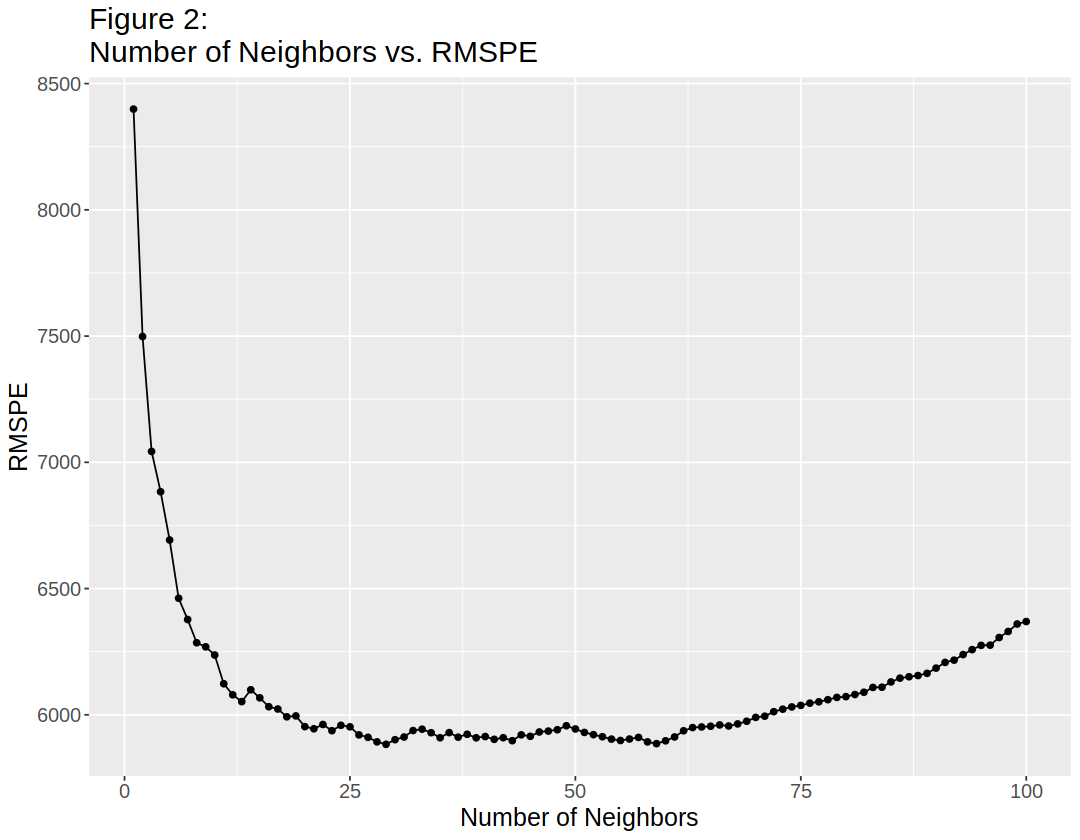

In [23]:
set.seed(1234)

# Graph of Neighbors vs RMSPE
options(repr.plot.width = 9, repr.plot.height = 7)

bike_tune_graph <- ggplot(bike_tune_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "RMSPE") +
    ggtitle("Figure 2: \nNumber of Neighbors vs. RMSPE") +
    theme(text = element_text(size = 15))

bike_tune_graph

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6052.852


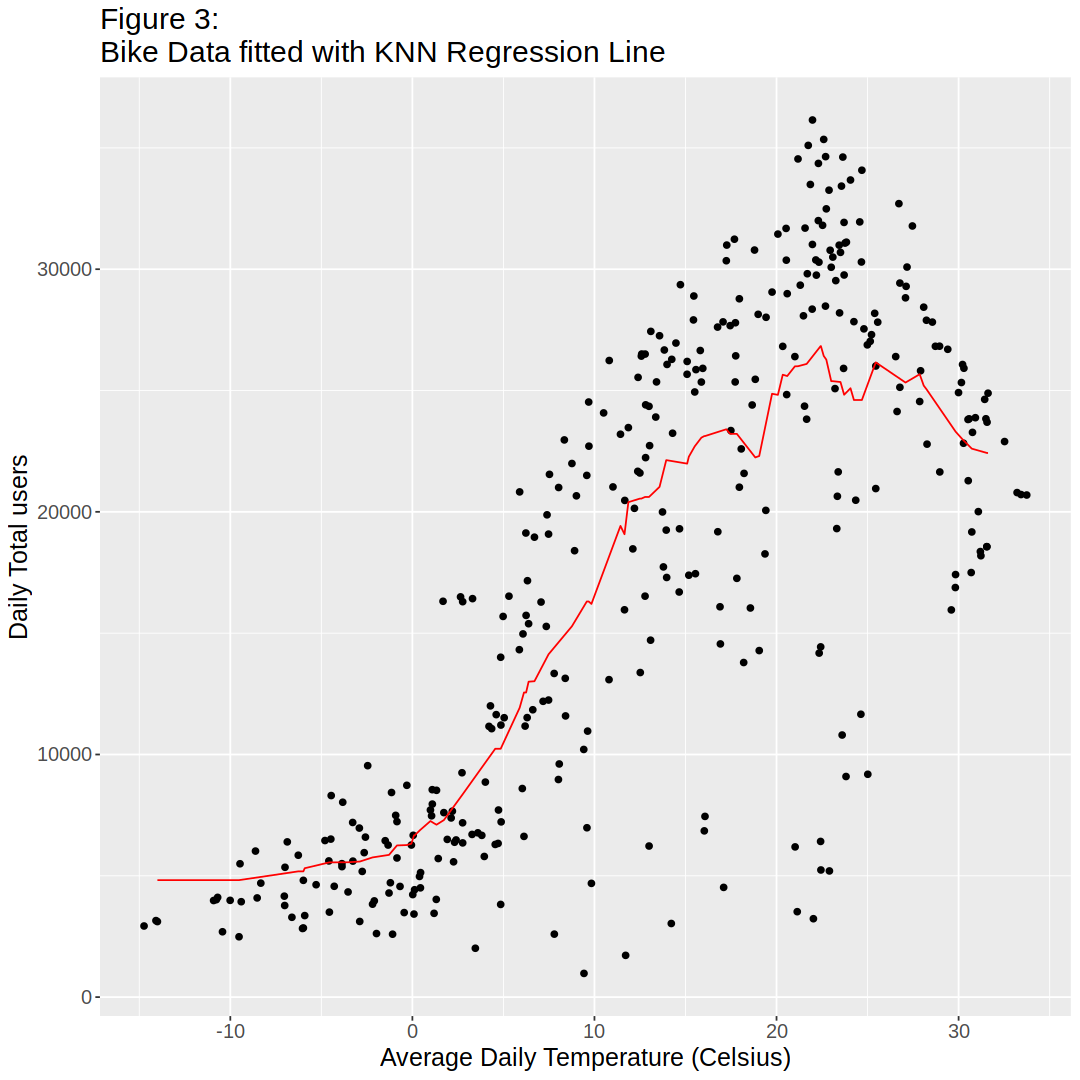

In [24]:
set.seed(1234)

# select k val with the smallest RMSPE
k_min <- bike_tune_results |> 
    filter(mean == min(mean)) |>
    select(neighbors) |>
    pull()

bike_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

bike_fit <- workflow() |>
    add_recipe(bike_recipe) |>
    add_model(bike_spec) |>
    fit(data = bike_training)

bike_preds <- bike_fit |>
    predict(bike_testing) |>
    bind_cols(bike_testing)

bike_summary <- bike_preds |>
    metrics(truth = total_users, estimate = .pred) |>filter(.metric == "rmse")

bike_summary

options(repr.plot.width = 9, repr.plot.height = 9)

bike_analysis_plot <- ggplot(bike_condensed, aes(x = avg_temp, y = total_users)) +
    geom_point() + 
    geom_line(data = bike_preds, mapping = aes(x = avg_temp, y = .pred), color = "red") + 
    labs(x = "Average Daily Temperature (Celsius)", y = "Daily Total users") + 
    ggtitle("Figure 3: \nBike Data fitted with KNN Regression Line") +
    theme(text = element_text(size = 15))

bike_analysis_plot

Rows: 8760 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Date, Seasons, Holiday, Functioning Day
dbl (10): Rented Bike Count, Hour, Temperature_Celsius, Humidity, Wind speed...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


date,rented_bike_count,hour,temperature_celsius,humidity,wind_speed_m_per_s,visibility_10m,dew_point_temperature_celsius,solar_radiation,rainfall_mm,snowfall_cm,seasons,holiday,functioning_day
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Yes
01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,Yes


date,avg_temp,total_users
<chr>,<dbl>,<dbl>
01/01/2018,-1.283333,4290
01/02/2018,-3.866667,5377
01/03/2018,0.450000,5132
01/04/2018,15.183333,17388
01/05/2018,20.341667,26820
01/06/2018,23.708333,31928


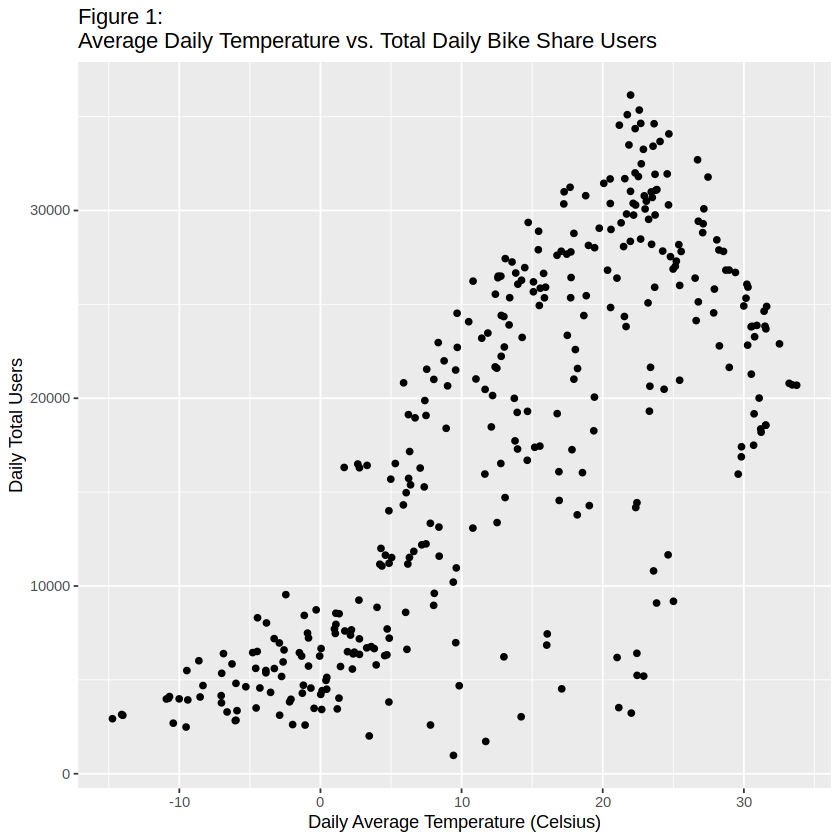

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6052.852


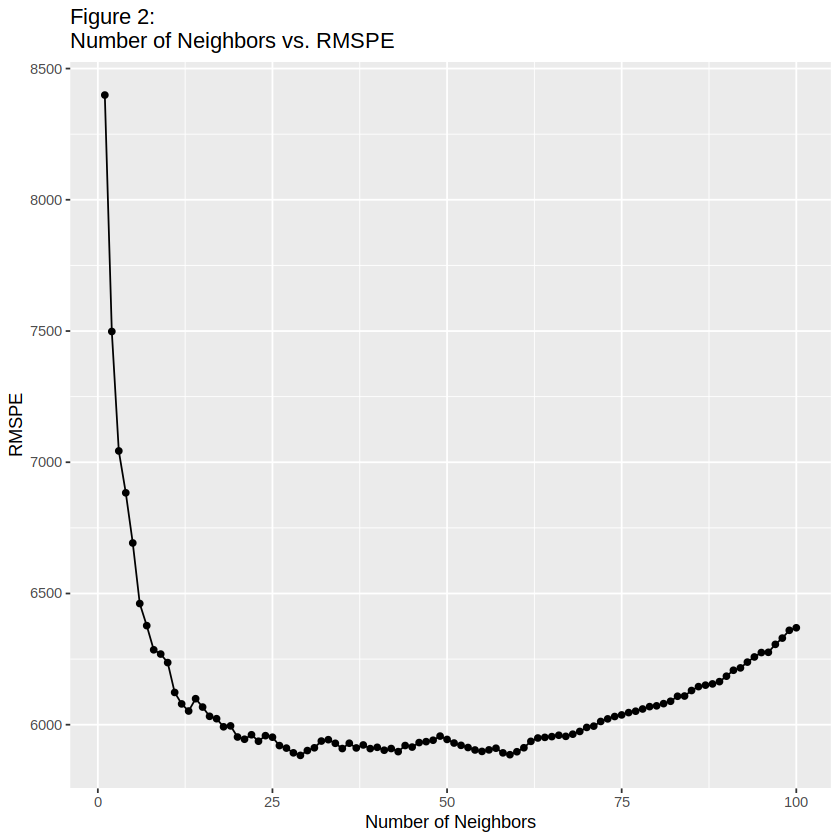

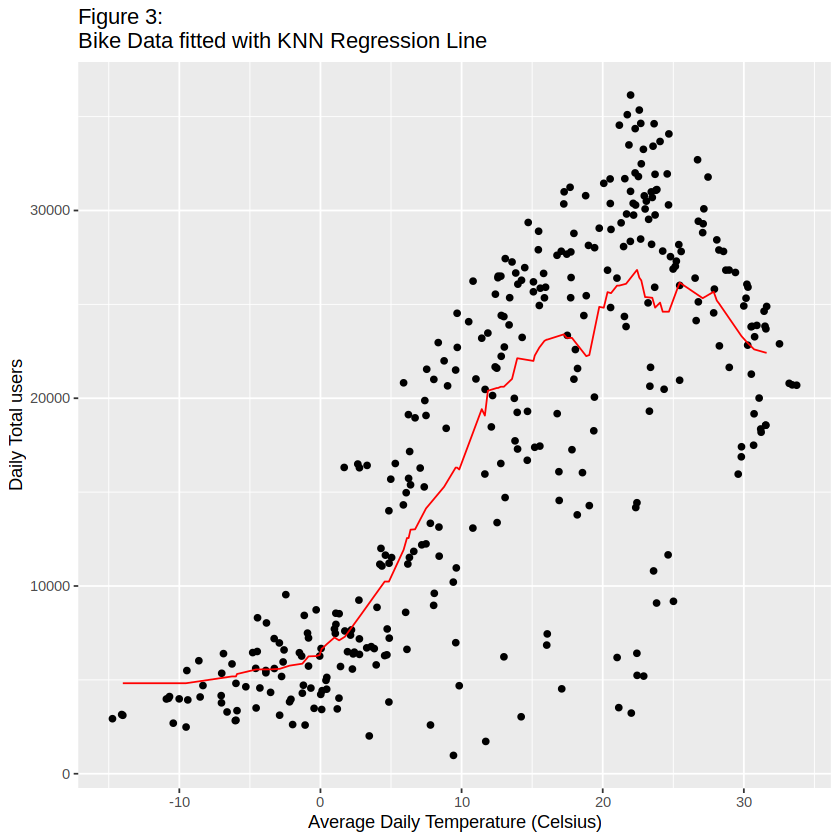

In [6]:
set.seed(1234)

# add captions for images

# read data from web
bike_url <- "https://raw.githubusercontent.com/caiwwei/dsci-project-4/main/SeoulBikeData.csv"
bike_data <- read_csv(bike_url) |>
    clean_names() # tidy column names in dataset to contain no spaces

# raw data with clean names
head(bike_data)

# convert data observations from hourly to daily by computing total daily users and average daily temperature
bike_condensed <- bike_data |>
    group_by(date) |> 
    filter(functioning_day == "Yes") |> # because we only care about days where the bike share service is operating
    summarize(avg_temp = mean(temperature_celsius), total_users = sum(rented_bike_count)) 

# summarized datatable
head(bike_condensed)

# split the data into training and testing; we choose to use a 75% training and 25% testing split 
bike_split <- initial_split(bike_condensed, prop = 0.75, strata = total_users)
bike_training <- training(bike_split)
bike_testing <- testing(bike_split)
# visualize training data with a scatter plot to depict relationship between average temperature and total users
bike_plot <- ggplot(bike_condensed, aes(x = avg_temp, y = total_users)) +
    geom_point() +
    xlab("Daily Average Temperature (Celsius)") +
    ylab("Daily Total Users") +
    ggtitle("Figure 1: \nAverage Daily Temperature vs. Total Daily Bike Share Users")

bike_plot

# create recipe
bike_recipe <- recipe(total_users ~ avg_temp, data = bike_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create specification to tune the model
bike_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# splits training data for cross validation
bike_vfold <- vfold_cv(bike_training, v = 5, strata = total_users)

bike_tune_workflow <- workflow() |>
    add_recipe(bike_recipe) |>
    add_model(bike_tune_spec)
k_vals <- tibble(neighbors = seq(from = 1, to = 100))

bike_tune_results <- bike_tune_workflow |>
    tune_grid(resamples = bike_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

# Graph of Neighbors vs RMSPE
bike_tune_graph <- ggplot(bike_tune_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "RMSPE") +
    ggtitle("Figure 2: \nNumber of Neighbors vs. RMSPE")

bike_tune_graph

# select k val with the smallest RMSPE
k_min <- bike_tune_results |> 
    filter(mean == min(mean)) |>
    select(neighbors) |>
    pull()

bike_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

bike_fit <- workflow() |>
    add_recipe(bike_recipe) |>
    add_model(bike_spec) |>
    fit(data = bike_training)

bike_preds <- bike_fit |>
    predict(bike_testing) |>
    bind_cols(bike_testing)

bike_summary <- bike_preds |>
    metrics(truth = total_users, estimate = .pred) |>filter(.metric == "rmse")

bike_summary

bike_analysis_plot <- ggplot(bike_condensed, aes(x = avg_temp, y = total_users)) +
    geom_point() + 
    geom_line(data = bike_preds, mapping = aes(x = avg_temp, y = .pred), color = "red") + 
    labs(x = "Average Daily Temperature (Celsius)", y = "Daily Total users") + 
    ggtitle("Figure 3: \nBike Data fitted with KNN Regression Line")

bike_analysis_plot